# Permutation feature importance 

In [ ]:
# Install OSMNX only if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install osmnx
    !pip install matplotlib==3.1.1 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from google.colab import files
import requests

In [ ]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1tfAjKLhhl3lteqf_EkFoyIPY2IdBJFVn'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("V2data_6mounts2022.csv.zip", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()
    !unzip V2data_6mounts2022.csv.zip

Archive:  V2data_6mounts2022.csv.zip
  inflating: data.csv                
  inflating: __MACOSX/._data.csv     


In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/data_processor.py')
    with open('data_processor.py', 'w') as f:
        f.write(r.text)
    r = requests.get('https://raw.githubusercontent.com/dominik117/data-science-toolkit/main/helper_notebooks/darkzone_creator.py')
    with open('darkzone_creator.py', 'w') as f:
        f.write(r.text)

import data_processor 
import darkzone_creator

In [ ]:
nIN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: df_main_url = '/content/data.csv'
else: df_main_url = '../../../Information/output/datav2.csv'
amenities_df = pd.read_csv(df_main_url, dtype = {'place.id': object})
amenities_df.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
amenities_df = data_processor.clean_df(amenities_df)
amenities_df = data_processor.aggregate_df(amenities_df)
amenities_df['row_type'] = "ground truth"
amenities_df = data_processor.make_date_features(amenities_df)
amenities_df = data_processor.make_coordinates_features(amenities_df)
amenities_df = data_processor.make_edge_length_feature(amenities_df)
amenities_df = data_processor.make_weather_features(amenities_df)
amenities_df, osm_columns = data_processor.make_osm_features(amenities_df)

# Feature Importances

#### Coefficients

In [ ]:
def score_for_feature(X, y):
  # Splitting
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  # Categorical & numeric
  all_categorical_features = ['date_utc', 'edge_id', 'edge_osmid', 'osm_highway',
                              'month', 'day', 'weekday', 'holiday', 'atm', 'bar', 
                              'bench', 'childcare', 'cinema',
       'clinic', 'fast_food', 'fountain', 'fuel', 'ice_cream', 'kindergarten',
       'marketplace', 'nightclub', 'parking', 'recycling', 'school', 'taxi',
       'toilets', 'vending_machine', 'waste_basket', 'waste_disposal']

  all_numeric_features = ['lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length',
       'temperature_max', 'temperature_min', 'temperature_mean',
       'precipitation', 'snowfall', 'humidity_max', 'humidity_min',
       'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min',
       'wind_speed_mean']

  categorical_features = X_train[[i for i in X_train.columns if i in all_categorical_features]].columns.tolist()
  numeric_features = X_train[[i for i in X_train.columns if i in all_numeric_features]].columns.tolist()
  
  #Categorical and numeric transformer
  categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
  
  numeric_transformer = Pipeline(steps=[("scaler", RobustScaler())])
  
  #Preprocessor
  preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer,
                                                       numeric_features),
                                               ("cat", categorical_transformer,
                                                       categorical_features)])
  #Model
  poisson_model = linear_model.PoissonRegressor()

  pipeline_poisson = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("poisson_model", poisson_model)
                              ])
  
  grid_search = {'poisson_model__alpha' : [1e-5, 1e-4, 1e-3],
               'poisson_model__max_iter' : [1000],
               }
               
  model = GridSearchCV(estimator=pipeline_poisson, param_grid=grid_search,
                     scoring='neg_mean_poisson_deviance', verbose=5, n_jobs=-1)
  model.fit(X_train,y_train)

  best_model = model.best_estimator_

  score = best_model.score(X_test, y_test)

  permut = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, n_jobs=-1
  )

  sorted_importances_idx = permut.importances_mean.argsort()
  importances = pd.DataFrame(
    permut.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
  )


  cols = list(X_test.columns)
  model = best_model[1]
  print(cols)
  print('\n')
  return importances, score, cols, model


In [ ]:
amenities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598807 entries, 0 to 598806
Data columns (total 78 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date_utc          598807 non-null  object 
 1   edge_id           598807 non-null  object 
 2   edge_osmid        598807 non-null  int64  
 3   osm_highway       598807 non-null  object 
 4   total_litter      598807 non-null  int64  
 5   1                 598807 non-null  int64  
 6   2                 598807 non-null  int64  
 7   3                 598807 non-null  int64  
 8   4                 598807 non-null  int64  
 9   5                 598807 non-null  int64  
 10  7                 598807 non-null  int64  
 11  8                 598807 non-null  int64  
 12  10                598807 non-null  int64  
 13  13                598807 non-null  int64  
 14  14                598807 non-null  int64  
 15  16                598807 non-null  int64  
 16  19                59

In [ ]:
permut_importance_df, score, cols, model = score_for_feature(amenities_df.drop(amenities_df.iloc[:, 4:35], axis=1), amenities_df['total_litter'])


In [ ]:
importance_df = pd.DataFrame({'Attribute': permut_importance_df.columns, 
                              'Importance': permut_importance_df.mean(axis=0).values})


In [ ]:
score

0.6404631540917769

In [ ]:
importance_df=importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Attribute,Importance
46,lon_east,7.457208e+11
45,lon_west,5.719898e+11
44,edge_length,1.492550e+01
43,lat_south,4.167240e+00
42,lat_north,3.843926e+00
41,osm_highway,2.104406e-01
40,edge_id,1.955742e-01
39,edge_osmid,1.834869e-01
38,month,1.243747e-01
37,date_utc,9.654846e-02


In [ ]:
importance_df.to_csv('all_features_permut_importances.csv')
files.download('all_features_permut_importances.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

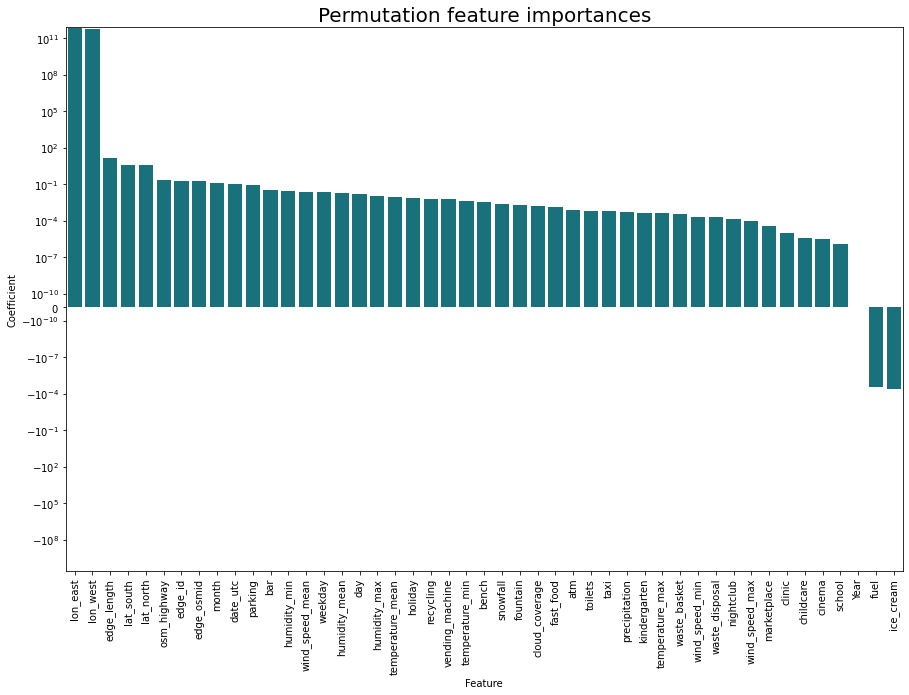

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=importance_df, x = 'Attribute', y='Importance', ax=ax, color='#087E8B')
ax.set_title('Permutation feature importances', size=20)
ax.set_xlabel("Feature")
plt.yscale('symlog', linthreshy=1e-10)
plt.xticks(rotation='vertical')
ax.set_ylabel("Coefficient");
fig.show()
fig.savefig('all_features_permut_importance_graph.pdf');
files.download('all_features_permut_importance_graph.pdf')